## Load Dependancies

In [ ]:
# Load libraries
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from collections import OrderedDict



In [ ]:
# check that GPU is recognized
print("Does PyTorch recognize the GPU?","Yes" if torch.cuda.is_available() else "No")
device="cuda" if torch.cuda.is_available() else "cpu"

Does PyTorch recognize the GPU? Yes


In [ ]:
cuda = torch.cuda.is_available()
if cuda:
  torch.set_default_tensor_type('torch.cuda.FloatTensor')
  a = torch.randn(3,3)
  print(a.device)

cuda:0


/usr/local/lib/python3.10/dist-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


cuda:0


## Generate the DataSet : Two Moons

In [ ]:
# Generate the Two Moons dataset
x_data, y_data = make_moons(
    n_samples=1000,
    shuffle=True,
    noise=0.15,
    random_state=42
)

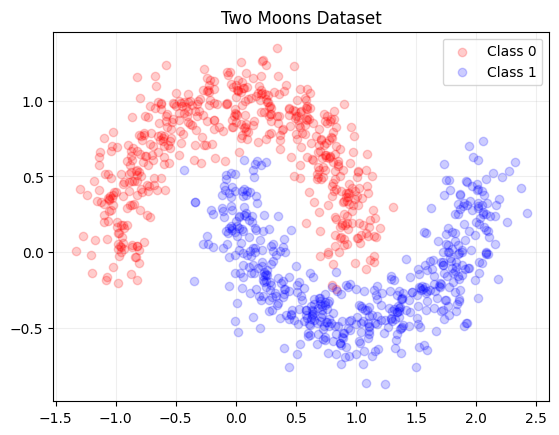

In [ ]:
# Plot the Two Moons dataset
class_colors = ["red", "blue"]
for i in range(len(np.unique(y_data))):
    plt.scatter(
        x_data[y_data == i, 0],
        x_data[y_data == i, 1],
        color=class_colors[i],
        alpha=0.2,
        label="Class "+str(i)
    )

plt.grid(alpha=0.2)
plt.legend()
plt.title("Two Moons Dataset")
plt.show()

## Construct PyTorch Model Class and DataLoader

In [ ]:
class LipschitzLayer(nn.Linear):
    def __init__(self, in_features, out_features, bias=True,
                 device=None, dtype=None):

        super().__init__(in_features, out_features, bias, device, dtype)

        self.c = nn.Parameter(torch.tensor(1, dtype=torch.float))

        self._eval_weight = self.weight
        self._update_eval_weight = True

    def weight_normalization(self, W):
        absrowsum = torch.sum(torch.abs(W), dim=1)
        softplus_c = torch.log(1 + torch.exp(self.c))
        scale = torch.clamp(softplus_c / absrowsum, max=1.0)
        return W * scale[:, None]

    def forward(self, x):
        if self.training:
            if not self._update_eval_weight:
                self._update_eval_weight = True
                print(type(x), type(self.weight_normalization(self.weight)))
            return F.linear(x, self.weight_normalization(self.weight), self.bias)
        elif not self.training:
            if self._update_eval_weight:
                self._eval_weight = nn.Parameter(self.weight_normalization(self.weight))
                self._update_eval_weight = False
            return F.linear(x, self._eval_weight, self.bias)

In [ ]:
class LipschitzMLP(nn.Module):

    def __init__(self, sizes = [2, 64, 64, 64, 1], is_lipschitz: bool = False, is_spectral_reg = False):

        super().__init__()

        # whether or not the network is initialized with Lipschitz regularized layers
        self.sizes = sizes

        if is_lipschitz:
            layer = LipschitzLayer
        else:
            layer = nn.Linear

        layer_dict = OrderedDict()
        for ii in range(len(self.sizes) - 2):
          layer_dict[f"Layer {ii}"] = layer(self.sizes[ii], self.sizes[ii+1])
          layer_dict[f"Layer {ii}_activation"] = nn.ReLU()
        # Last Layer
        layer_dict[f"hidden{len(self.sizes) - 2}"] = layer(self.sizes[-2], self.sizes[-1])
        layer_dict[f"hidden{len(self.sizes) - 2}_activation"] = nn.Sigmoid()

        self._layers = nn.Sequential(layer_dict)

    def forward(self, x):
        return self._layers(x)

    def get_lipschitz_loss(self):
      #for the experiment 2
        prod = None
        for m in self._layers.modules():
            if isinstance(m, LipschitzLayer):
                if prod is None:
                    prod = m.c
                else:
                    prod = prod * torch.log(1 + torch.exp(m.c))
        #if prod < 0:
        #    print(prod)
        return prod

    def get_spectral_norm(self):
      # for the experiment 3
      res = 0
      for m in self._layers.modules():
        if isinstance(m, nn.Linear):
          res += torch.linalg.norm(m.weight)
      return res

    def get_spectral_norm_layer(self):
      # for the plot
      res =[]
      for m in self._layers.modules():
        if isinstance(m, nn.Linear):
          res.append(torch.linalg.norm(m.weight).to(torch.float32))
      return torch.tensor(res)


In [ ]:
class TwoMoons(torch.utils.data.Dataset):
    def __init__(self, x_data, y_data):
        self.X = torch.from_numpy(x_data).to(device)
        self.Y = torch.from_numpy(y_data).unsqueeze(1).float().to(device)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return [self.X[idx], self.Y[idx]]

## Define Plot_Boundary function



In [23]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Plot the scatter plot and the decision boundary
def plot_boundary(model):

  x0_grid = np.linspace(-1.5, 2.5, num=100)
  x1_grid = np.linspace(-1, 1.5, num=100)
  pred_grid = torch.from_numpy(np.array(np.meshgrid(x0_grid, x1_grid)))
  pred_grid = pred_grid.to("cuda")

  pred_array = torch.reshape(pred_grid,(2, pred_grid.shape[1]*pred_grid.shape[2]))
  pred_array = torch.transpose(pred_array, 0,1)

  def makeGridPrediction(model, pred_array):
      model_array_preds = model(pred_array.float())
      model_grid_preds = torch.flip(
          torch.reshape(
              torch.transpose(model_array_preds, 0, 1),
              (pred_grid.shape[1], pred_grid.shape[2])
          ),
          [0])


      return model_grid_preds.cpu().detach().numpy()

  fig, ax = plt.subplots()
  preds_ = makeGridPrediction(model, pred_array)
  divider = make_axes_locatable(ax)


  im = ax.imshow(
      preds_,
      extent=[x0_grid[0], x0_grid[-1], x1_grid[0], x1_grid[-1]],
      cmap='seismic_r',
      alpha=0.5)

  # Plot the data again
  class_colors = ["red", "blue"]
  for i in range(len(np.unique(y_data))):
      ax.scatter(
          x_data[y_data == i, 0],
          x_data[y_data == i, 1],
          color=class_colors[i],
          alpha=0.2,
          label="Class "+str(i)
      )

  cax = divider.append_axes('right', size='5%', pad=0.05)
  fig.colorbar(im, cax=cax, orientation='vertical')

  plt.grid(alpha=0.2)
  plt.legend()
  #plt.title("Two Moons Dataset - Learned Decision Boundary")
  #plt.show()


  #plt.title("Two Moons Dataset - Learned Decision Boundary")
  #plt.show()


## Train Model

In [ ]:
## TRAIN THE MODEL ##

# For future plots

def train(model, optimizer, loss_function, train_data, num_epochs, sizes):
  #to train the model and keep the evolution of loss, accuracy and spectral norm for the epochs
  loss_history = np.zeros((num_epochs))
  accuracy_history = np.zeros((num_epochs))
  lipschitz_history = np.zeros((num_epochs, len(sizes)-1))


  for epoch in range(num_epochs):
    if not model.training:
      model.train()
    for batch, (inputs, targets) in enumerate(train_data):
      inputs = inputs.to(device)
      targets = targets.to(device)
      predictions = model(inputs.float())


      loss = loss_function(predictions, targets, model)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Plot Loss and Accuracy
      loss_history[epoch] = loss.item()/len(train_data)
      num_correct = torch.eq(predictions.round().bool(), targets.bool()).sum()
      accuracy_history[epoch] = num_correct/targets.size(0)
      lipschitz_history[epoch,:] = model.get_spectral_norm_layer().cpu().detach().numpy()


    if epoch % 50 == 0 :
      print(f"Epoch: {epoch+1:02d}/{num_epochs} | Loss: {loss_history[epoch]:.5f} \t | Accuracy: {accuracy_history[epoch]:.5f}")

  return model, loss_history, accuracy_history, lipschitz_history

   # plot_boundary(model)

def define_model(cfg):
  # function to define a model based on a configuration
  torch.manual_seed(0)  #  for repeatable results
  model = LipschitzMLP(sizes= cfg["sizes"], is_lipschitz=cfg["lipschitz"]).to(device)
#  model.to(device)

  # Define Loss Function and Optimizer

  optimizer = torch.optim.Adam(model.parameters(), lr=cfg["learning_rate"])

  loss_ = nn.BCELoss()
  if cfg["lipschitz"]:
      loss_function = lambda pred, y, model: loss_(pred.squeeze(), y.squeeze()) + cfg["alpha"] * model.get_lipschitz_loss()
  elif cfg["spectral_reg"]:
      loss_function = lambda pred, y, model: loss_(pred.squeeze(), y.squeeze()) + cfg["lambd"] * model.get_spectral_norm()
  else:
      loss_function = lambda pred, y, model: loss_(pred.squeeze(), y.squeeze())
  return model, optimizer, loss_function

def plot_history(loss_history, accuracy_history):
  #plot the loss an accuracy depending on the epoch
  fig, ax1 = plt.subplots()
  ax2 = ax1.twinx()
  ax1.plot(range(len(loss_history)), loss_history, 'g-', linewidth=3, label="Loss")
  ax2.plot(range(len(accuracy_history)), accuracy_history,
         'b-', linewidth=3, label="Accuracy")
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Loss", fontsize=16)
  ax2.set_ylabel("Accuracy", fontsize=16)
  ax2.set_ylim([0, 1.05])
  ax1.set_xlim([0, len(loss_history)])
  ax1.legend(bbox_to_anchor=(1, 0.8), fontsize=14)
  ax2.legend(bbox_to_anchor=(1, 0.9), fontsize=14)

def plot_lipschitz(lipschitz_history):
  # to plot for a model the evolution of the spectral norm of each layer
  len_size = len(lipschitz_history[0,:])
  plt.figure()
  for i in range(len_size):
    plt.plot(range(len(lipschitz_history[:,i])), lipschitz_history[:,i], label = "layer "+str(i))
  plt.title("comparison spectral normweight by layer")
  plt.legend()
  plt.show()

def compare_models(list_config_model):
#to compare the models and plot all the relevant figures for the comparison between the configurations
  list_models = []
  list_loss = []
  list_accuracy = []
  list_lipschitz = []

  for i, cfg in enumerate(list_config_model):
    print("\nNew training ", i)
    model, optimizer, loss_function = define_model(cfg)

    two_moons = TwoMoons(x_data, y_data)
    train_data = torch.utils.data.DataLoader(two_moons, batch_size=cfg["batch_size"])

    model, loss_history, accuracy_history, lipschitz_history = train(model, optimizer, loss_function, train_data, cfg["num_epochs"], cfg["sizes"])
    list_models.append(model)
    list_loss.append(loss_history)
    list_accuracy.append(accuracy_history)
    list_lipschitz.append(lipschitz_history)

    plt.figure()
    plot_boundary(model)
    plt.show()

  #plt.figure(figsize=(20,50))
  #for i in range(len(list_models)):
  #  plt.subplot(1, len(list_config_model)+1, i+1)
  #  plot_boundary(list_models[i])
  #plt.show()
  #plt.figure(figsize=(20,50))
  for i in range(len(list_models)):
  #  plt.subplot(1, len(list_config_model)+1, i+1)
    plot_history(list_loss[i], list_accuracy[i])

  for i in range(len(list_models)):
  #  plt.subplot(1, len(list_config_model)+1, i+1)
    plot_lipschitz(list_lipschitz[i])
  #plt.show()






In [34]:
# we define the configurations. We have to indicate which experiment with the lipschitz and spacral_reg parameters


cfg_1 = {"learning_rate": 10e-3,
         "sizes": [2, 16, 16, 16, 1],
         "lipschitz": False,
         "alpha": 5*10e-5,
         "spectral_reg": False,
         "lambd": 10e-2,
         "num_epochs": 50,
         "batch_size": 128
}

cfg_2 = {"learning_rate": 10e-3,
         "sizes": [2, 16, 16, 16, 1],
         "lipschitz": True,
         "alpha": 0.2*10e-5,
         "spectral_reg": False,
         "lambd": 10e-2,
         "num_epochs": 200,
         "batch_size": 128
}


cfg_3 = {"learning_rate": 10e-3,
         "sizes": [2, 16, 16, 16, 1],
         "lipschitz": False,
         "alpha": 5*10e-5,
         "spectral_reg": True,
         "lambd": 0.3e-2,
         "num_epochs": 100,
         "batch_size": 128
}

list_cfg = [cfg_1, cfg_2, cfg_3]




New training  0
Epoch: 01/50 | Loss: 0.07215 	 | Accuracy: 0.82692


<Figure size 640x480 with 0 Axes>

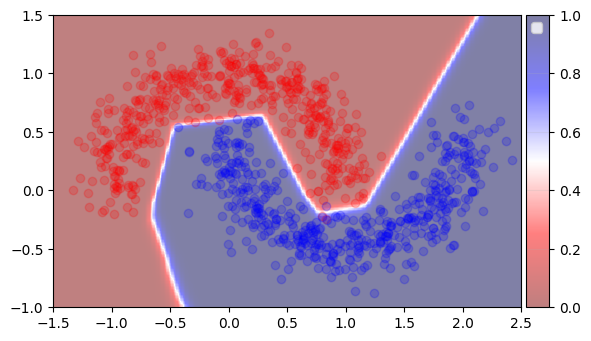


New training  1
Epoch: 01/200 | Loss: 0.08154 	 | Accuracy: 0.79808
Epoch: 51/200 | Loss: 0.00472 	 | Accuracy: 0.99038
Epoch: 101/200 | Loss: 0.00438 	 | Accuracy: 0.99038
Epoch: 151/200 | Loss: 0.00445 	 | Accuracy: 0.99038


<Figure size 640x480 with 0 Axes>

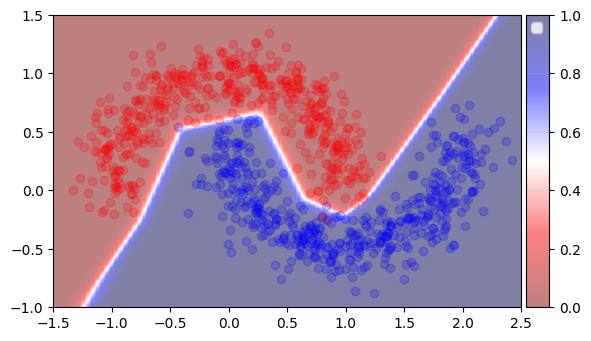


New training  2
Epoch: 01/100 | Loss: 0.07543 	 | Accuracy: 0.82692
Epoch: 51/100 | Loss: 0.00875 	 | Accuracy: 0.99038


<Figure size 640x480 with 0 Axes>

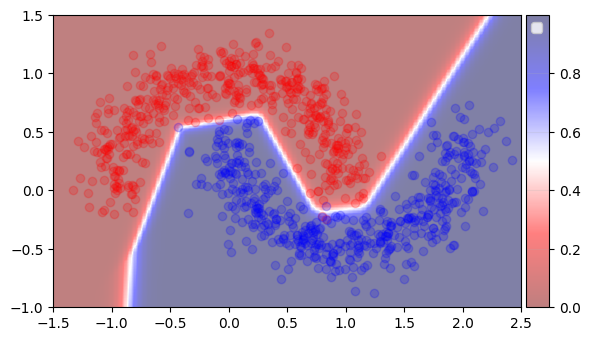

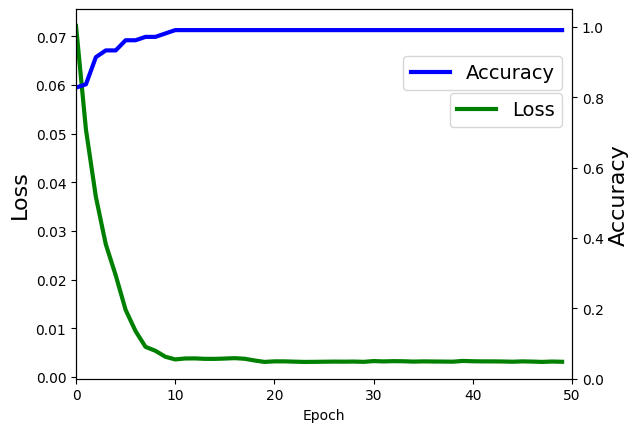

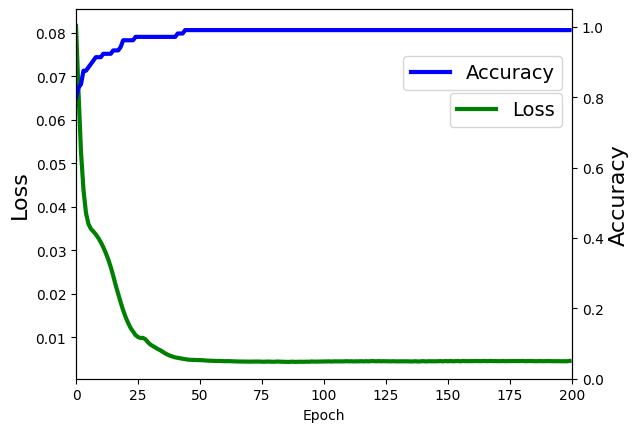

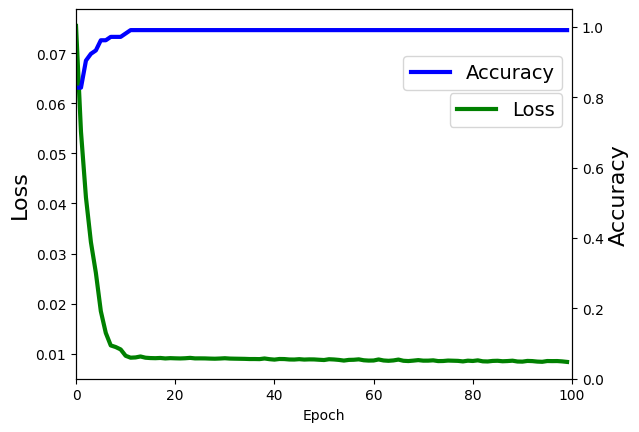

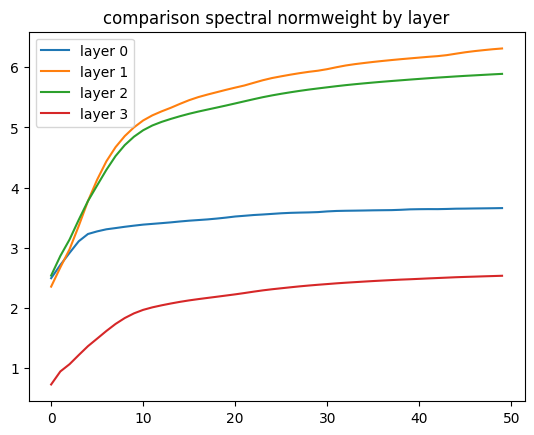

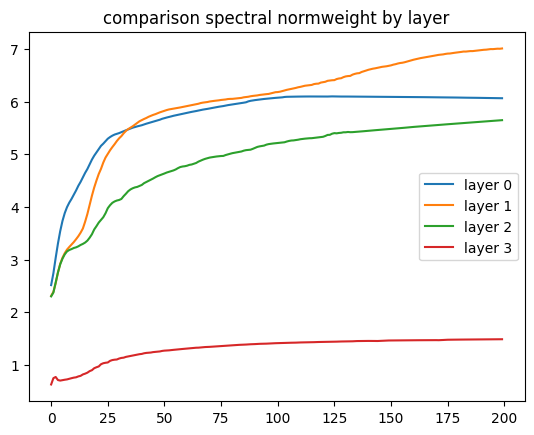

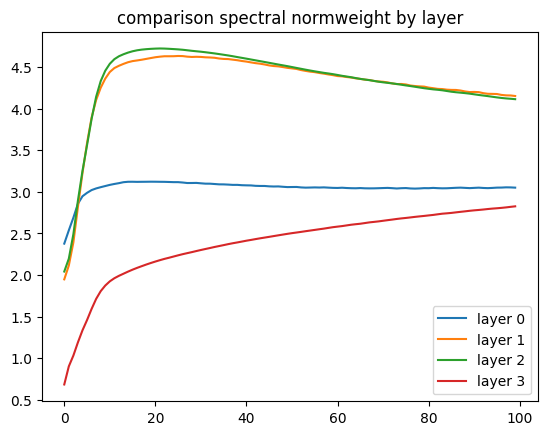

In [35]:
compare_models(list_cfg)